In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [3]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [4]:
y.shape, tx.shape, x.shape
# y=w0+x*w1 -> we create tx=[1,x] to deal with the offset (w0)

((10000,), (10000, 2), (10000,))

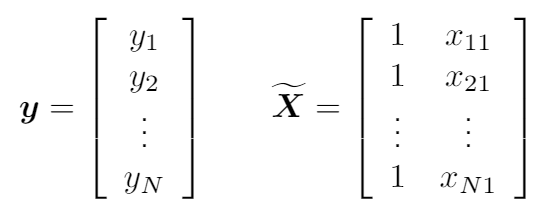

In [5]:
from IPython.display import Image
Image('./y_x.png', width=300,height=200)

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function

### Exercise 1
- columns of $\tilde{X}$ -> number of samples corresponding to each wight (w)
- rows of $\tilde{X}$ -> number of weights (w)
- to account for the first column of w -> w0
- y.shape = (3,) and tx.shape = (3,2). tx[3,2] -> heigh of the 3rd person

Fill in the `compute_loss` function below:

In [6]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    err=y-tx.dot(w)
    N=len(y)
    return 0.5*np.power(err,2).sum()/N

# 2. Grid Search

Fill in the function `grid_search()` below:

In [7]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    for (w0_ind,w0) in enumerate(grid_w0):
        for (w1_ind,w1) in enumerate(grid_w1):
            losses[w0_ind,w1_ind]=compute_loss(y,tx,np.array([w0,w1]))
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.793541019523236, w0*=71.42857142857142, w1*=15.306122448979579, execution time=1.352 seconds


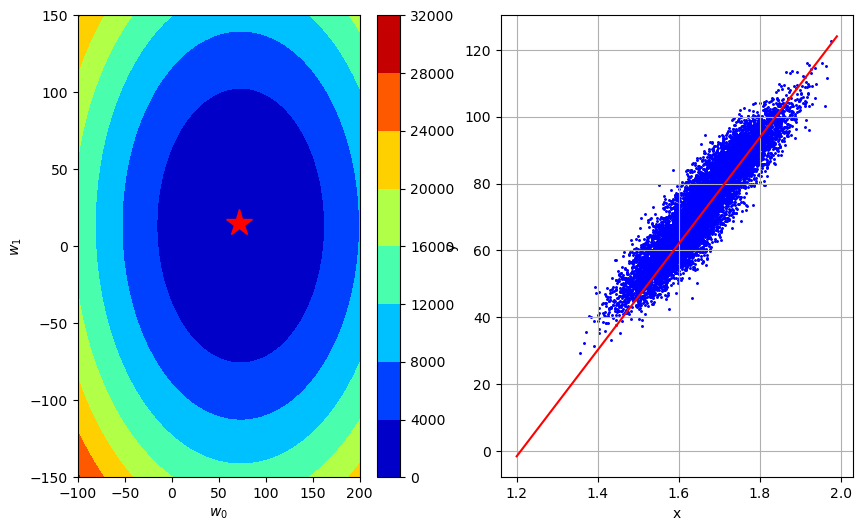

In [8]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
# fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [9]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    err=y-tx.dot(w)
    N=len(y)
    return -tx.T.dot(err)/N

Please fill in the functions `gradient_descent` below:

In [10]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute gradient and loss
        gradient=compute_gradient(y,tx,w)
        loss=compute_loss(y,tx,w)
        # update w
        w=w-gamma*gradient
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, g_L0={gd0:.2}, g_L1={gd1:.2}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, gd0=gradient[0], gd1=gradient[1], w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [11]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, g_L0=-7.3e+01, g_L1=-1.3e+01, w0=7.329392200210475, w1=1.3479712434989204
GD iter. 1/49: loss=2264.6350560300057, g_L0=-6.6e+01, g_L1=-1.2e+01, w0=13.92584518039996, w1=2.5611453626479217
GD iter. 2/49: loss=1837.2777140793814, g_L0=-5.9e+01, g_L1=-1.1e+01, w0=19.862652862570464, w1=3.653002069882027
GD iter. 3/49: loss=1491.1182670993776, g_L0=-5.3e+01, g_L1=-9.8, w0=25.205779776523926, w1=4.635673106392729
GD iter. 4/49: loss=1210.729115045574, g_L0=-4.8e+01, g_L1=-8.8, w0=30.014593999082066, w1=5.520077039252341
GD iter. 5/49: loss=983.6139018819921, g_L0=-4.3e+01, g_L1=-8.0, w0=34.34252679938437, w1=6.316040578826014
GD iter. 6/49: loss=799.6505792194914, g_L0=-3.9e+01, g_L1=-7.2, w0=38.237666319656455, w1=7.032407764442313
GD iter. 7/49: loss=650.6402878628656, g_L0=-3.5e+01, g_L1=-6.4, w0=41.7432918879013, w1=7.677138231496978
GD iter. 8/49: loss=529.9419518639996, g_L0=-3.2e+01, g_L1=-5.8, w0=44.89835489932168, w1=8.257395651846178
GD iter

In [12]:
# Time Visualization
from ipywidgets import *


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [13]:
def select_random(y,tx):
    random_position=np.random.randint(0,len(y))
    return y[random_position:random_position+1], tx[random_position:random_position+1]

In [14]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    err=y-tx.dot(w)
    return -tx.T.dot(err)

def select_random(y,tx):
    random_position=np.random.randint(0,len(y))
    return y[random_position:random_position+1], tx[random_position:random_position+1]

def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

#     for n_iter in range(max_iters):
#         for yb, xb in batch_iter(y,tx,batch_size):
#             # compute gradient on batch
#             stochastic_grad=compute_stoch_gradient(yb,xb,w)
#             # compute loss
#             loss=compute_loss(yb,xb,w)
#             # update w
#             w=w-gamma*stochastic_grad

#             ws.append(w)
#             losses.append(loss)
#             print(
#                 "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
#                     bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
#                 )
#             )

    """ I am selecting a random sample form y,tx dataset without using batch_iter() function, 
        because in each iteration it shuffels the both datasets (y,tx), making it run slower
    """
    for n_iter in range(max_iters):
        yb, xb = select_random(y,tx)
        # compute gradient on batch
        stochastic_grad=compute_stoch_gradient(yb,xb,w)
        # compute loss
        loss=compute_loss(yb,xb,w)
        # update w
        w=w-gamma*stochastic_grad

        ws.append(w)
        losses.append(loss)
        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [15]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=1171.9063316186064, w0=4.8412939006398, w1=-8.625456467525112
SGD iter. 1/49: loss=1265.2992079537328, w0=9.871799258859257, w1=-13.694226616637334
SGD iter. 2/49: loss=5577.723121971977, w0=20.433733856244316, w1=1.8705926793216783
SGD iter. 3/49: loss=1271.8969941976852, w0=25.477337714989936, w1=1.2217276730666782
SGD iter. 4/49: loss=1878.2678555912642, w0=31.606396134667897, w1=6.3427192309072895
SGD iter. 5/49: loss=749.3121491322328, w0=35.47760305017172, w1=6.840970922624799
SGD iter. 6/49: loss=799.7513870281485, w0=39.47698146944677, w1=6.79934606183332
SGD iter. 7/49: loss=589.9251903392545, w0=42.91187649066432, w1=4.493675072332481
SGD iter. 8/49: loss=597.6925114068117, w0=46.36931054327273, w1=7.633255559136943
SGD iter. 9/49: loss=217.7101749769973, w0=48.455983373291836, w1=6.002327049168355
SGD iter. 10/49: loss=697.846723294103, w0=52.19188145352396, w1=8.520531739032101
SGD iter. 11/49: loss=65.30569019504796, w0=53.334734814152945, w1=7.4477035

In [16]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [17]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=True, add_outlier=True)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [18]:
y.shape, tx.shape

((202,), (202, 2))

In [19]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

gd_losses, gd_ws = gradient_descent(y,tx,w_initial,max_iters,gamma)

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, g_L0=-7.4e+01, g_L1=-1.1e+01, w0=51.84746409844842, w1=7.724426406192425
GD iter. 1/49: loss=318.2821247015965, g_L0=-2.2e+01, g_L1=-3.3, w0=67.40170332798297, w1=10.041754328050116
GD iter. 2/49: loss=88.6423556165128, g_L0=-6.7, g_L1=-0.99, w0=72.06797509684336, w1=10.736952704607413
GD iter. 3/49: loss=67.97477639885521, g_L0=-2.0, g_L1=-0.3, w0=73.46785662750146, w1=10.9455122175746
GD iter. 4/49: loss=66.11469426926604, g_L0=-0.6, g_L1=-0.089, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, g_L0=-0.18, g_L1=-0.027, w0=74.01381042445813, w1=11.026850427631798
GD iter. 6/49: loss=65.93222021235334, g_L0=-0.054, g_L1=-0.008, w0=74.0516072257859, w1=11.032481534481912
GD iter. 7/49: loss=65.93086421248087, g_L0=-0.016, g_L1=-0.0024, w0=74.06294626618423, w1=11.034170866536945
GD iter. 8/49: loss=65.93074217249236, g_L0=-0.0049, g_L1=-0.00072, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.930

In [20]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [21]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    err=y-tx.dot(w)
    N=len(y)
    sign=np.sign(err)
    return (-tx.T.dot(sign))/N

In [22]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute subgradient and loss
        subgradient=compute_subgradient_mae(y,tx,w)
        loss=compute_loss(y,tx,w)
        # update w by subgradient
        w=w-gamma*subgradient
        
        ws.append(w)
        losses.append(loss)
#         print(
#             "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
#                 bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
#             )
#         )
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, sg_L0={gd0:.2}, sg_L1={gd1:.2}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, gd0=subgradient[0], gd1=subgradient[1], w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [23]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=2869.8351145358524, sg_L0=-1.0, sg_L1=-8.7e-16, w0=0.7, w1=6.109524327590712e-16
SubGD iter. 1/499: loss=2818.2326504374046, sg_L0=-1.0, sg_L1=-8.7e-16, w0=1.4, w1=1.2219048655181425e-15
SubGD iter. 2/499: loss=2767.120186338956, sg_L0=-1.0, sg_L1=-8.7e-16, w0=2.0999999999999996, w1=1.832857298277214e-15
SubGD iter. 3/499: loss=2716.4977222405073, sg_L0=-1.0, sg_L1=-8.7e-16, w0=2.8, w1=2.443809731036285e-15
SubGD iter. 4/499: loss=2666.365258142059, sg_L0=-1.0, sg_L1=-8.7e-16, w0=3.5, w1=3.054762163795356e-15
SubGD iter. 5/499: loss=2616.72279404361, sg_L0=-1.0, sg_L1=-8.7e-16, w0=4.2, w1=3.665714596554428e-15
SubGD iter. 6/499: loss=2567.570329945162, sg_L0=-1.0, sg_L1=-8.7e-16, w0=4.9, w1=4.276667029313499e-15
SubGD iter. 7/499: loss=2518.9078658467133, sg_L0=-1.0, sg_L1=-8.7e-16, w0=5.6000000000000005, w1=4.887619462072571e-15
SubGD iter. 8/499: loss=2470.735401748265, sg_L0=-1.0, sg_L1=-8.7e-16, w0=6.300000000000001, w1=5.498571894831642e-15
SubGD iter. 9/49

In [24]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [25]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        for yb, xb in batch_iter(y,tx,batch_size):
            # compute subgradient and loss
            subgradient=compute_subgradient_mae(yb,xb,w)
            loss=compute_loss(yb,xb,w)
            # update w by subgradient
            w=w-gamma*subgradient

            ws.append(w)
            losses.append(loss)
        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [26]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=2694.5693161641257, w0=0.7, w1=-0.3821259845503349
SubSGD iter. 1/499: loss=4307.931974725852, w0=1.4, w1=0.4970463276804717
SubSGD iter. 2/499: loss=2074.5417747127412, w0=2.0999999999999996, w1=0.12146048939390197
SubSGD iter. 3/499: loss=3891.6198587189683, w0=2.8, w1=0.7361214705242887
SubSGD iter. 4/499: loss=2518.016381024905, w0=3.5, w1=0.7882818160539993
SubSGD iter. 5/499: loss=3888.9122307038224, w0=4.2, w1=1.621619398613576
SubSGD iter. 6/499: loss=2985.6353054863735, w0=4.9, w1=2.0001591819703073
SubSGD iter. 7/499: loss=2238.644614266608, w0=5.6000000000000005, w1=1.3810180265559246
SubSGD iter. 8/499: loss=3509.0418039914616, w0=6.300000000000001, w1=2.0045061488421023
SubSGD iter. 9/499: loss=1215.328445233729, w0=7.000000000000001, w1=1.2703918258411133
SubSGD iter. 10/499: loss=2325.789508210606, w0=7.700000000000001, w1=1.2379628180737536
SubSGD iter. 11/499: loss=2493.267369224067, w0=8.4, w1=1.38129340866827
SubSGD iter. 12/499: loss=2618.33

In [27]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>